# Analysis of TCGA database through GDC

## 1. Initial settings and import libraries

In [39]:
#set working directry
setwd("/Users/csi16/Desktop/cbioinformatics/200407-/TCGA")

#import libraries
require(edgeR)
require(ComplexHeatmap)
require(gprofiler2)

## 2. Sample information

In [40]:
sample_information <- read.delim(
  "gdc_sample_sheet.2020-04-15.tsv",
  stringsAsFactor=FALSE,
  header = TRUE)
FileID <- sample_information$File.ID
FileName <- sample_information$File.Name
SampleType <- sample_information$Sample.Type
NofSample <- length(FileID)

## 3. Create dataframe

In [41]:
all.data <- data.frame(NA)
colnames(all.data) <- c("gene")
for (i in 1:NofSample){
  FilePath <- paste("data", FileID[i], FileName[i], sep = "/")
  temp <- read.delim(
    FilePath,
    stringsAsFactor=FALSE,
    header = FALSE)
  colnames(temp) <- c("gene",i)
  all.data <- merge(all.data, temp, all=T)
}
all.data <- all.data[-nrow(all.data),]
all.data <- all.data[-(1:5),]
rownames(all.data) <- all.data[,1]
all.data <- all.data[,-1]

## 4. Remove "Reccurent Tumor"

In [42]:
unique(SampleType)
RTindex <- which(SampleType == "Recurrent Tumor")
FileName <- FileName[-RTindex]
SampleType <- SampleType[-RTindex]
all.data <- all.data[,-RTindex]

[1] "Primary Tumor"       "Solid Tissue Normal" "Recurrent Tumor"

## 5. Normalization (cpm)

In [43]:
obj <- as.logical(rowSums(all.data) > 0)
all.data <- all.data[obj,]
mil <- 1000000
nf <- mil/colSums(all.data)
all.data_cpm <- sweep(all.data, 2, nf, "*")

## 6. Clustering

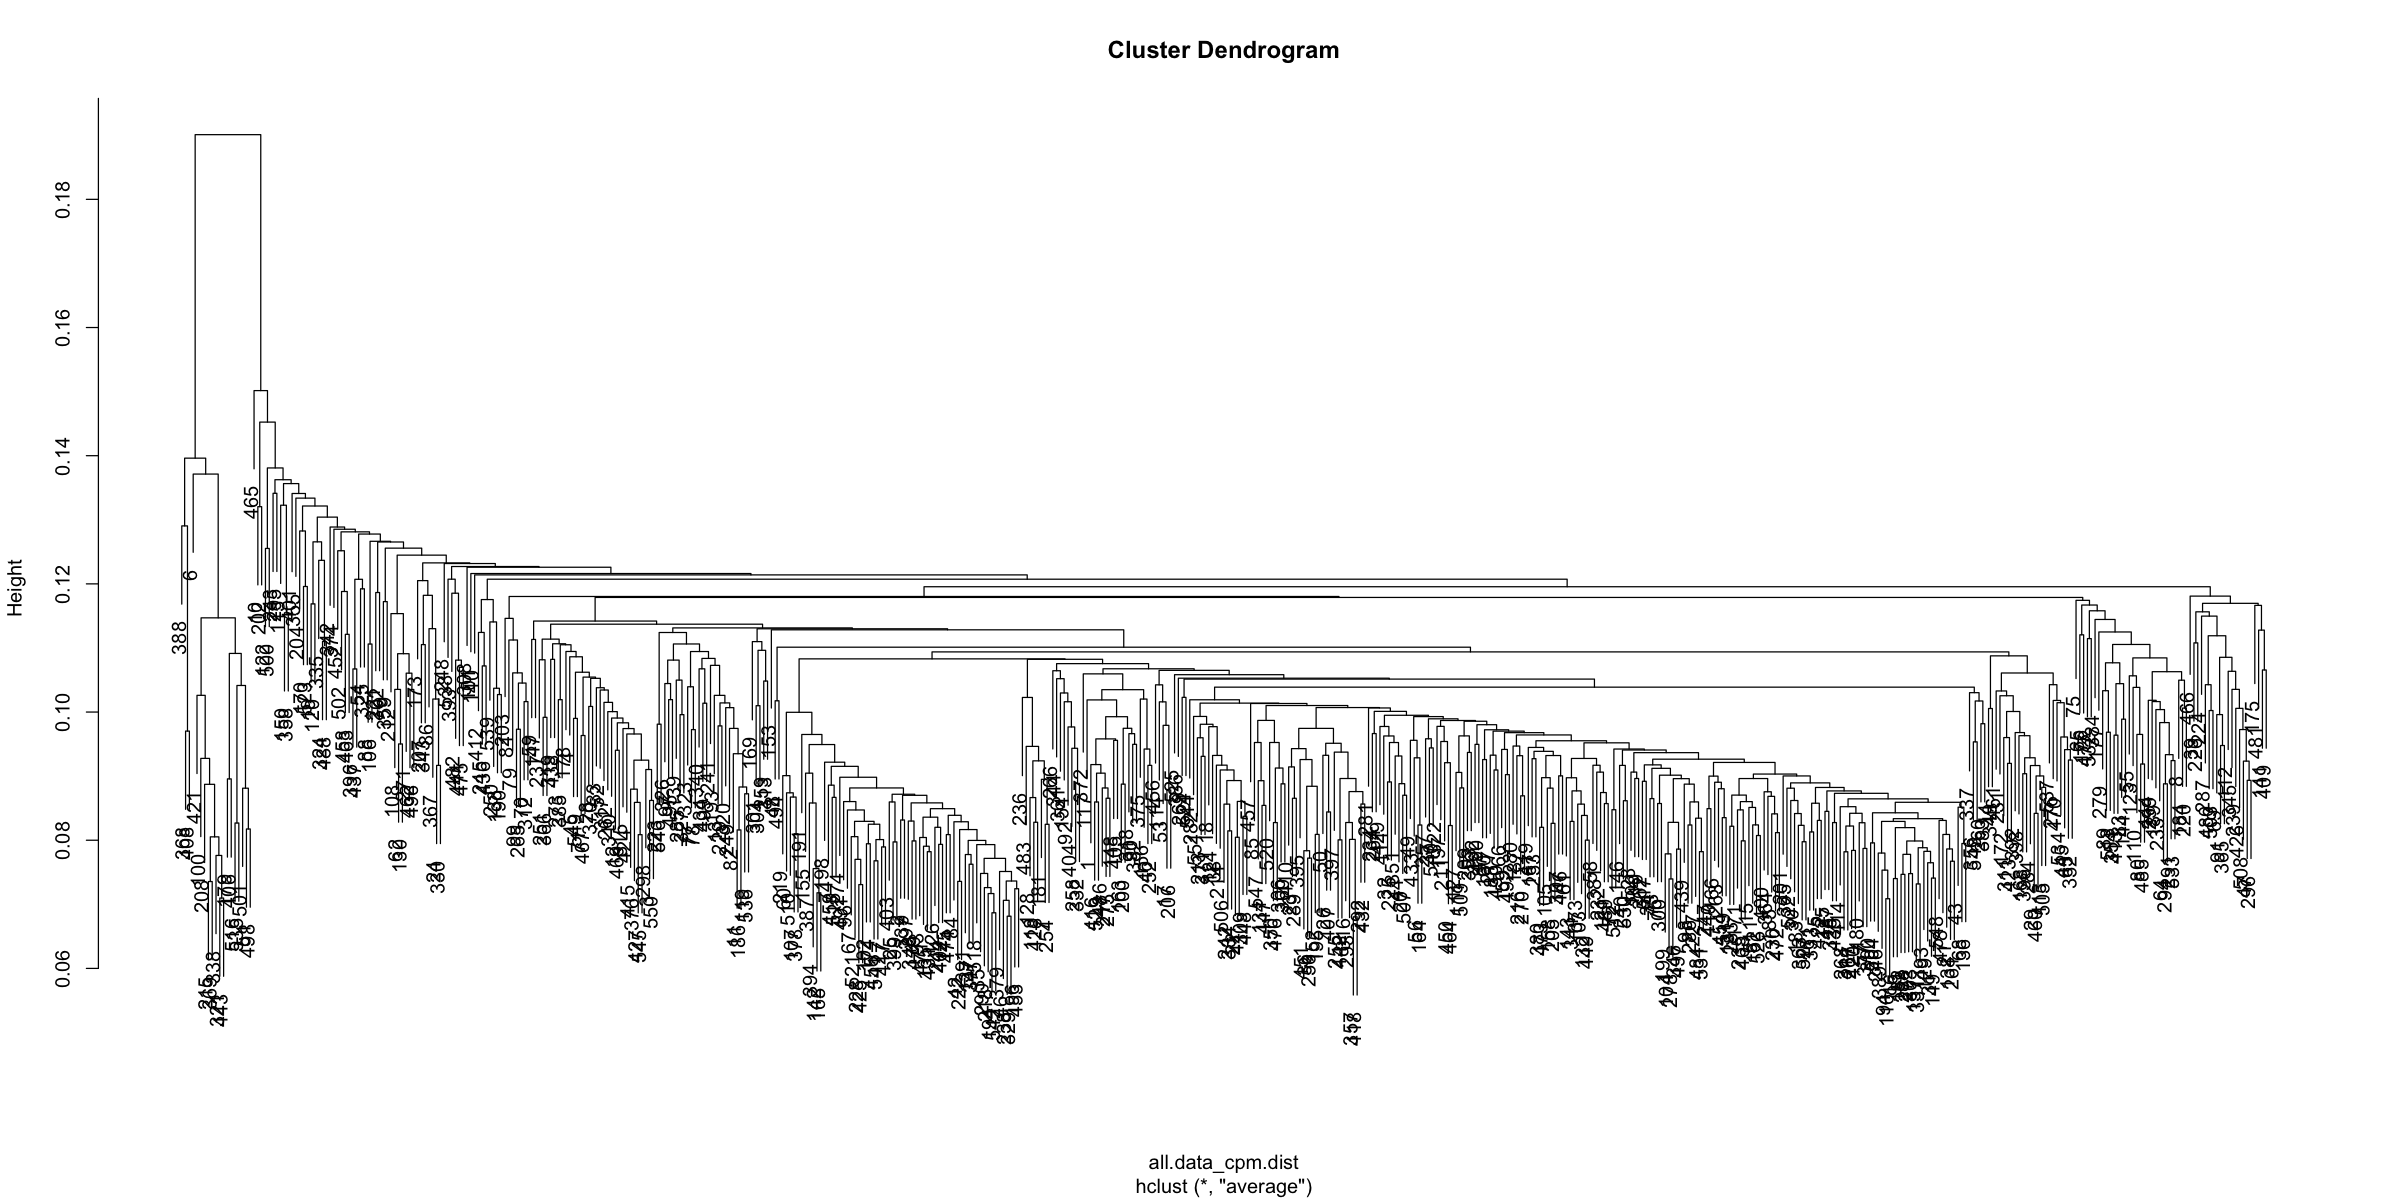

In [44]:
all.data_cpm.dist <- as.dist(1 - cor(all.data_cpm, method = "spearman"))
out_cluster <- hclust(all.data_cpm.dist, method = "average")
options(repr.plot.width = 20, repr.plot.height = 10)
plot(out_cluster)

## 7. PCA

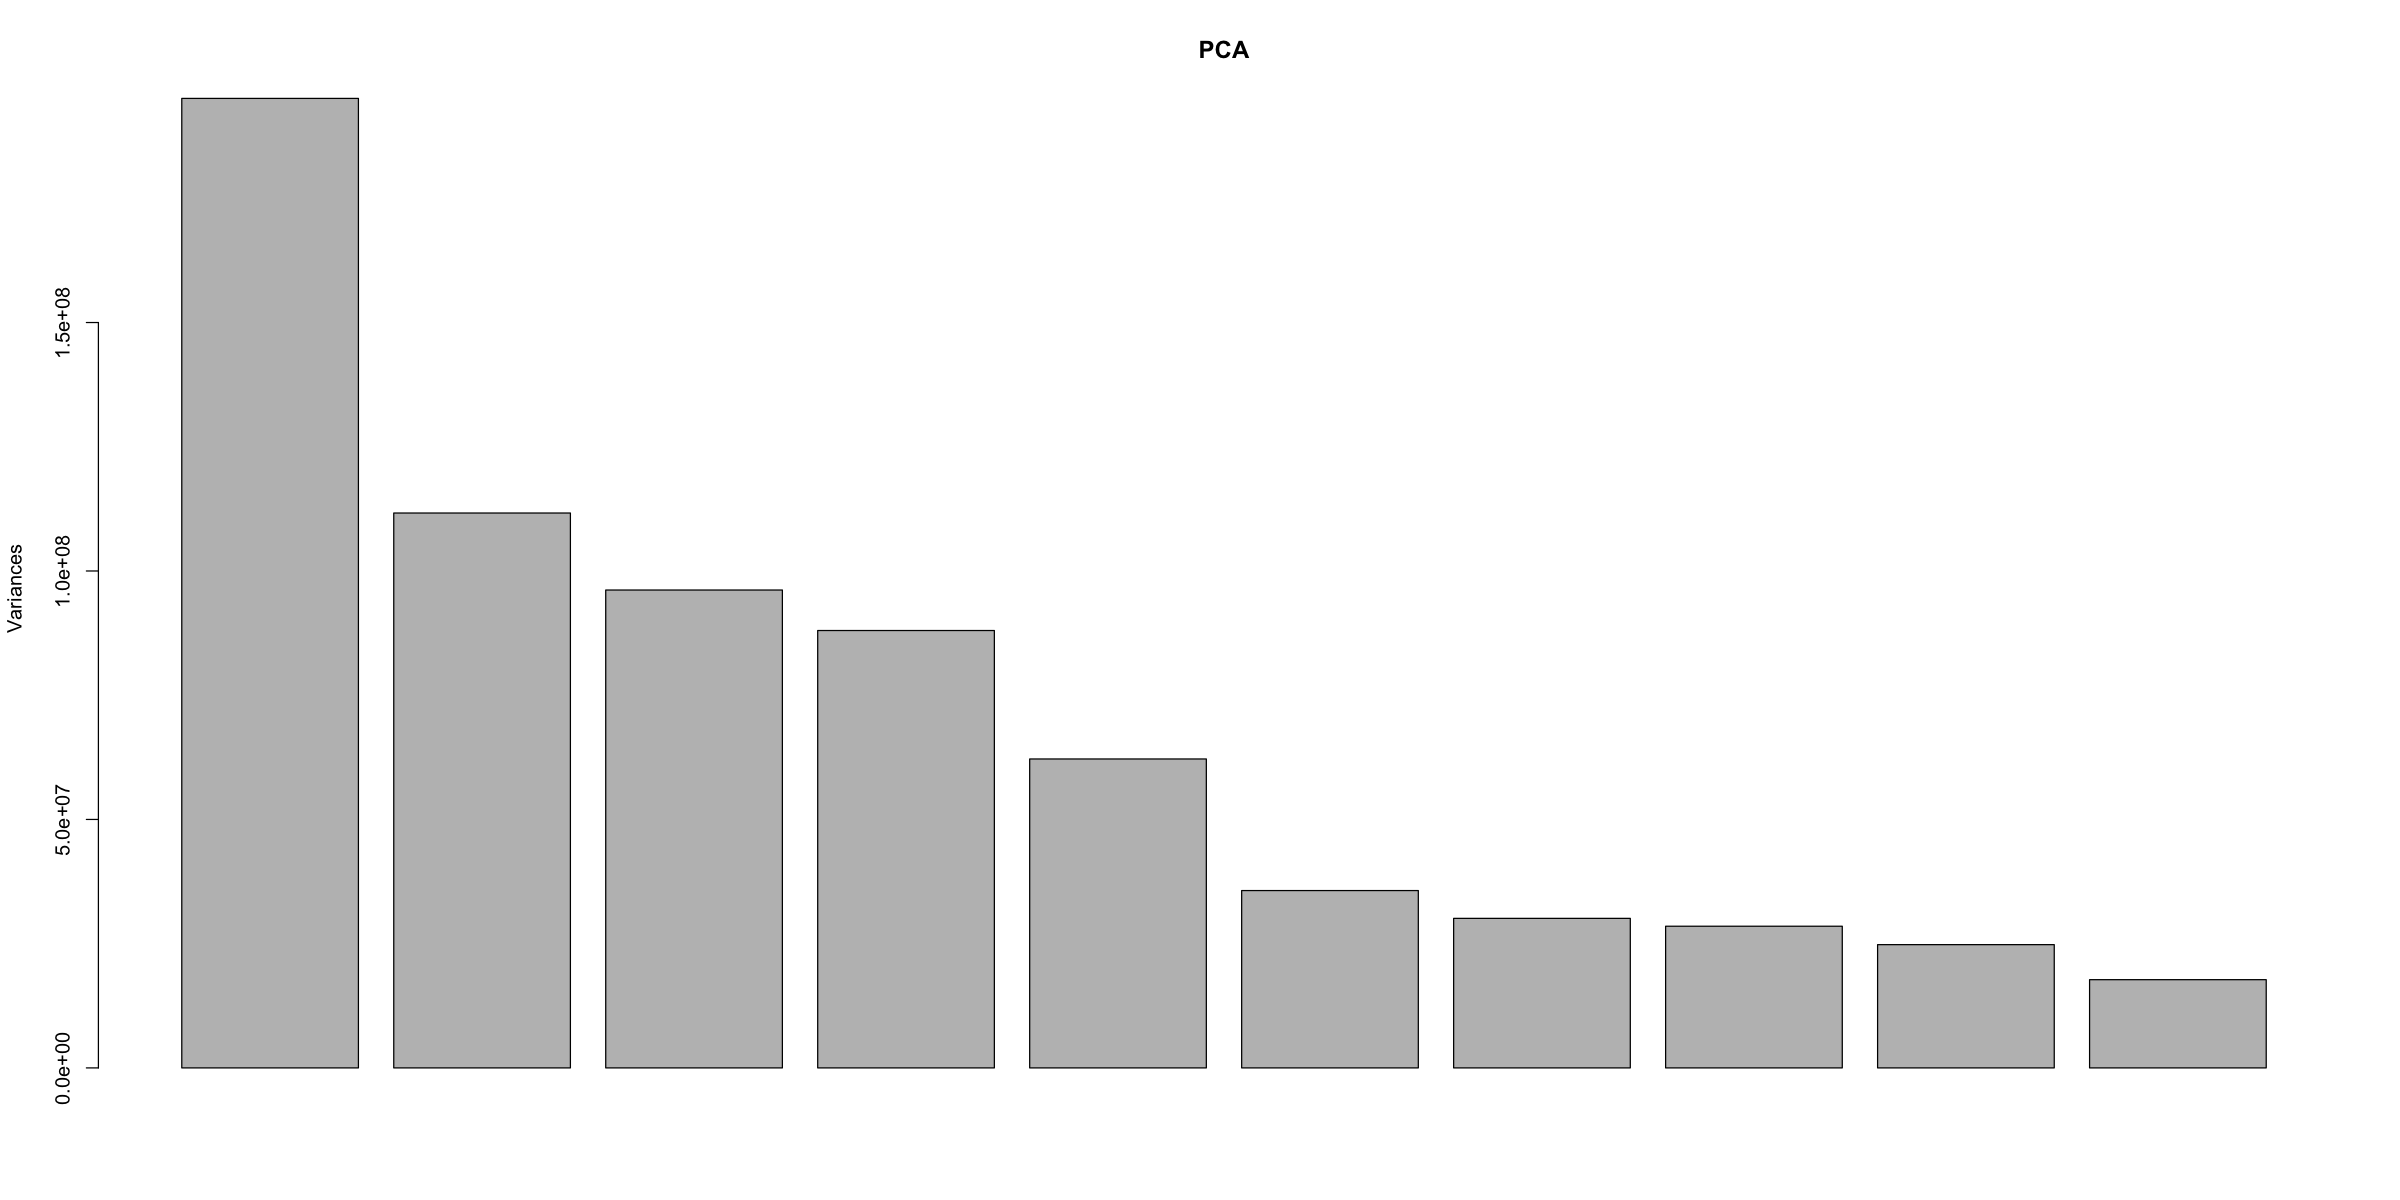

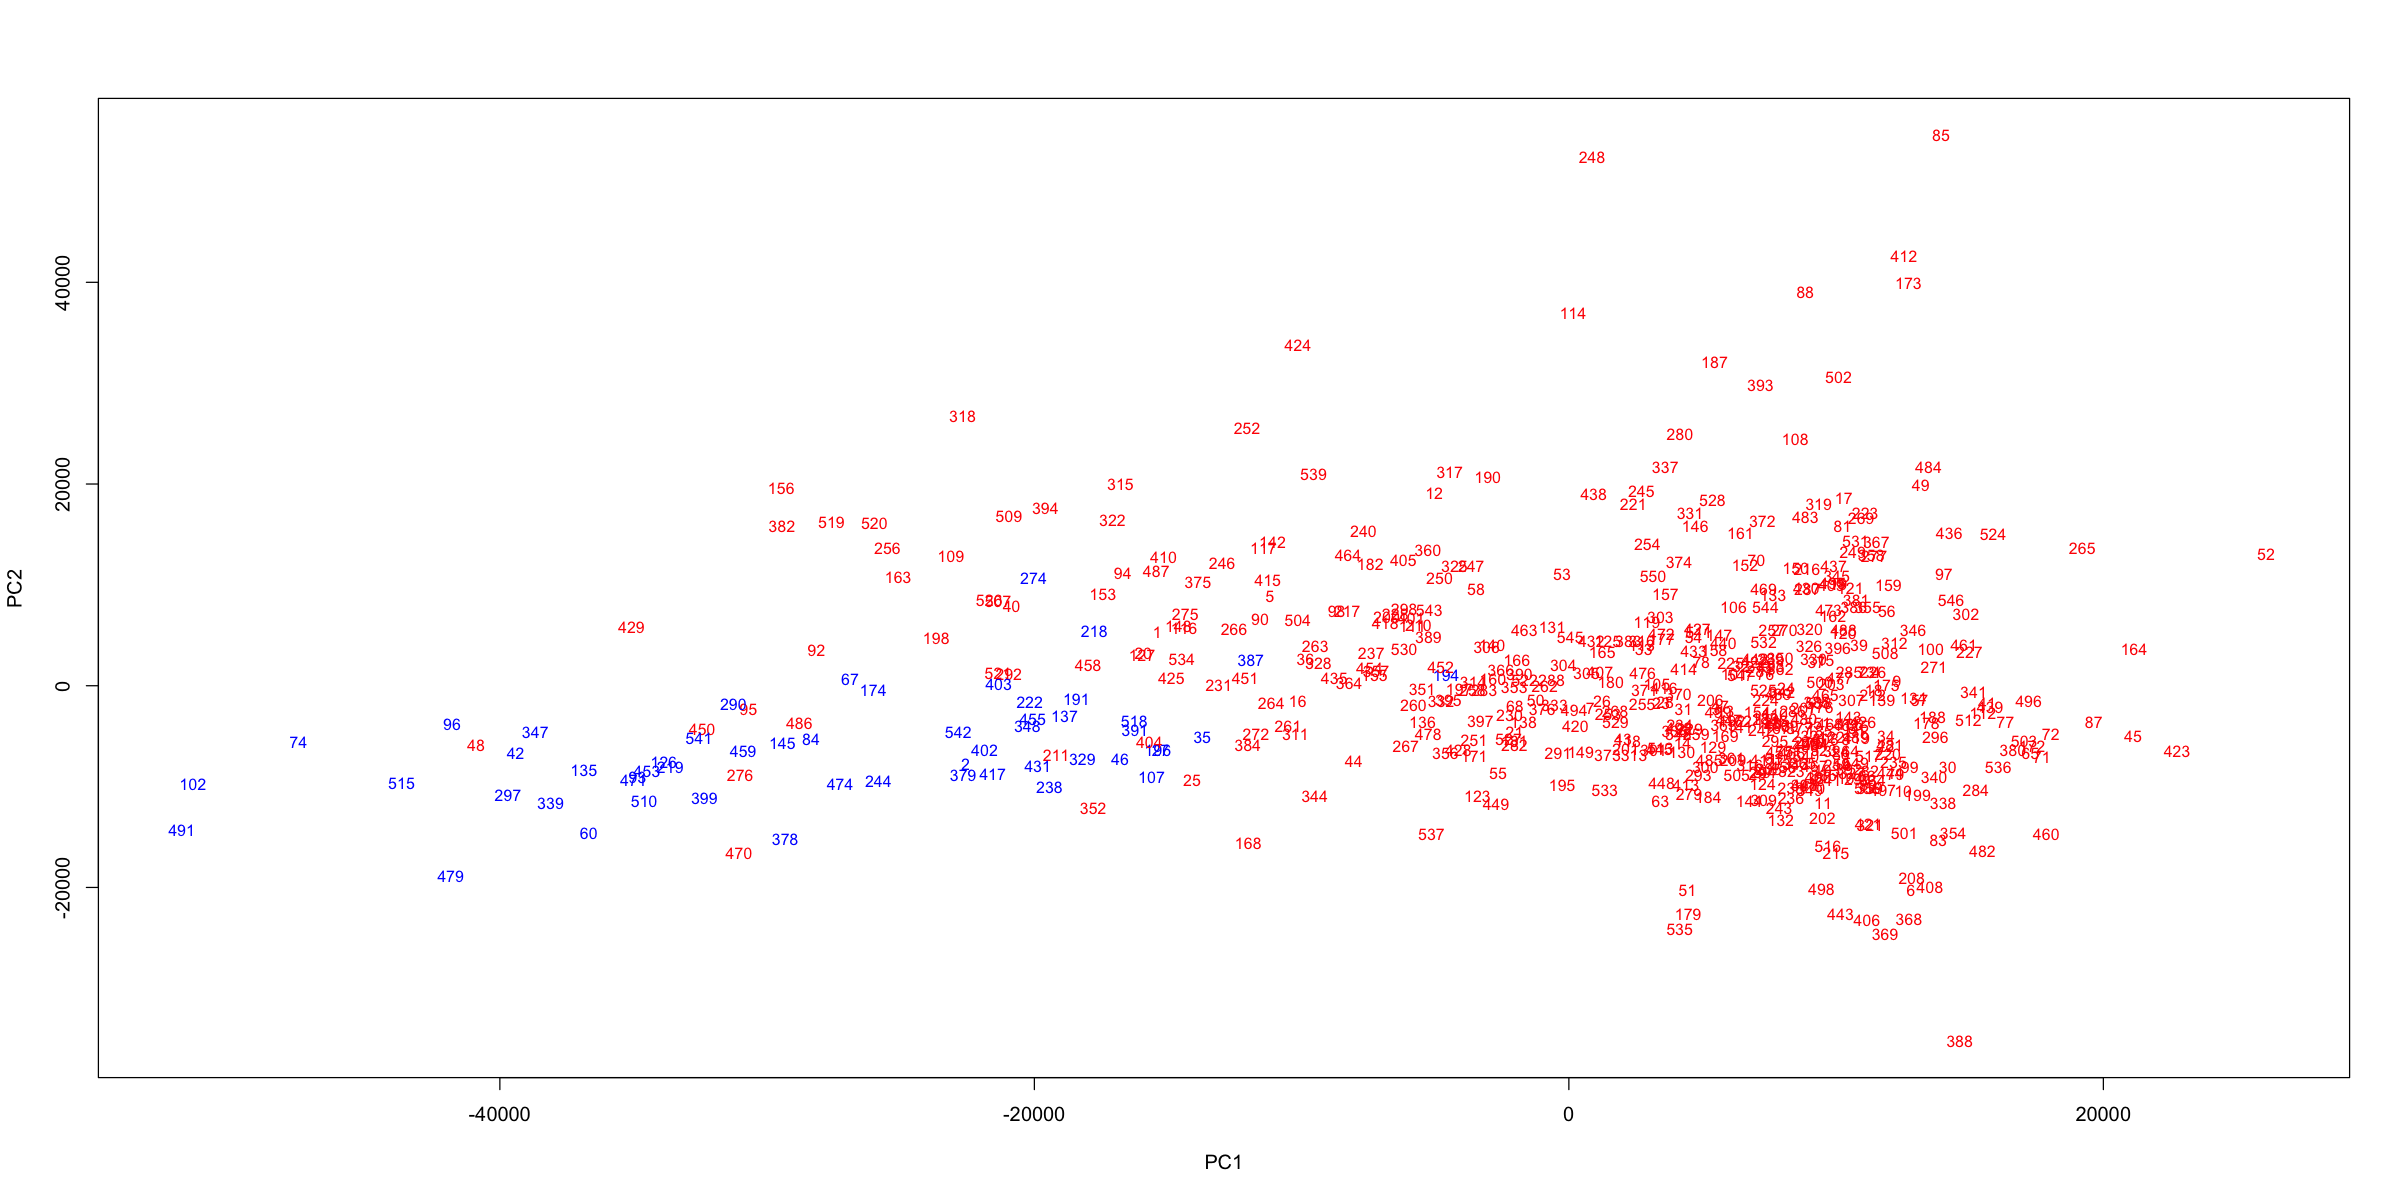

In [45]:
pca <- prcomp(t(all.data_cpm))
col <- ifelse(SampleType == "Solid Tissue Normal", "blue", "red")
plot(pca, main="PCA")
#PC1 & PC2
plot(pca$x[, c(1, 2)], type = 'n')
text(pca$x[, c(1, 2)], label = colnames(all.data_cpm), col = col, cex = 0.8)

## 8. DEG

In [46]:

param_FDR <- 0.01
d <- DGEList(counts = all.data_cpm, group = SampleType)
d <- calcNormFactors(d)
norm.factors <- d$samples$norm.factors/mean(d$samples$norm.factors)#正規化係数の平均が1になるように正規化したものがTCCパッケージで得られるものと同じです

#正規化後のデータをファイルに出力
ef.libsizes <- colSums(all.data_cpm)*norm.factors#effective library sizesというのはlibrary sizesに正規化係数を掛けたものなのでそれを計算した結果をef.libsizesに格納
normalized.count <- sweep(all.data_cpm, 2, mean(ef.libsizes)/ef.libsizes, "*")#正規化後のデータを取り出してnormalized.countに格納

d <- estimateCommonDisp(d)             #the quantile-adjusted conditional maximum likelihood (qCML)法でcommon dispersionを計算している
d <- estimateTagwiseDisp(d)            #the quantile-adjusted conditional maximum likelihood (qCML)法でmoderated tagwise dispersionを計算している
out <- exactTest(d)                    #exact test (正確確率検定)で発現変動遺伝子を計算した結果をoutに格納
#tmp <- topTags(out, n=nrow(data), sort.by="none")#検定結果を抽出
p.value <- out$table$PValue            #p値をp.valueに格納
q.value <- p.adjust(p.value, method="BH")#q値をq.valueに格納
logFC <- out$table$logFC
FC <- 2^logFC
ranking <- rank(p.value)               #p.valueでランキングした結果をrankingに格納
#sum(q.value < param_FDR)               #FDR閾値(q.value < param_FDR)を満たす遺伝子数を表示

#ファイルに保存(テキストファイル)
tmp <- cbind(rownames(all.data_cpm), normalized.count, p.value, q.value,logFC,FC,ranking)#入力データの右側にp.value、q.value、rankingを結合した結果をtmpに格納

DEG<-tmp
upDEG <- rownames(tmp[which((tmp$q.value < param_FDR) & (tmp$FC > 10)),])
downDEG <- rownames(tmp[which((tmp$q.value < param_FDR) & (tmp$FC < 0.1)),])


## 9. MA plot

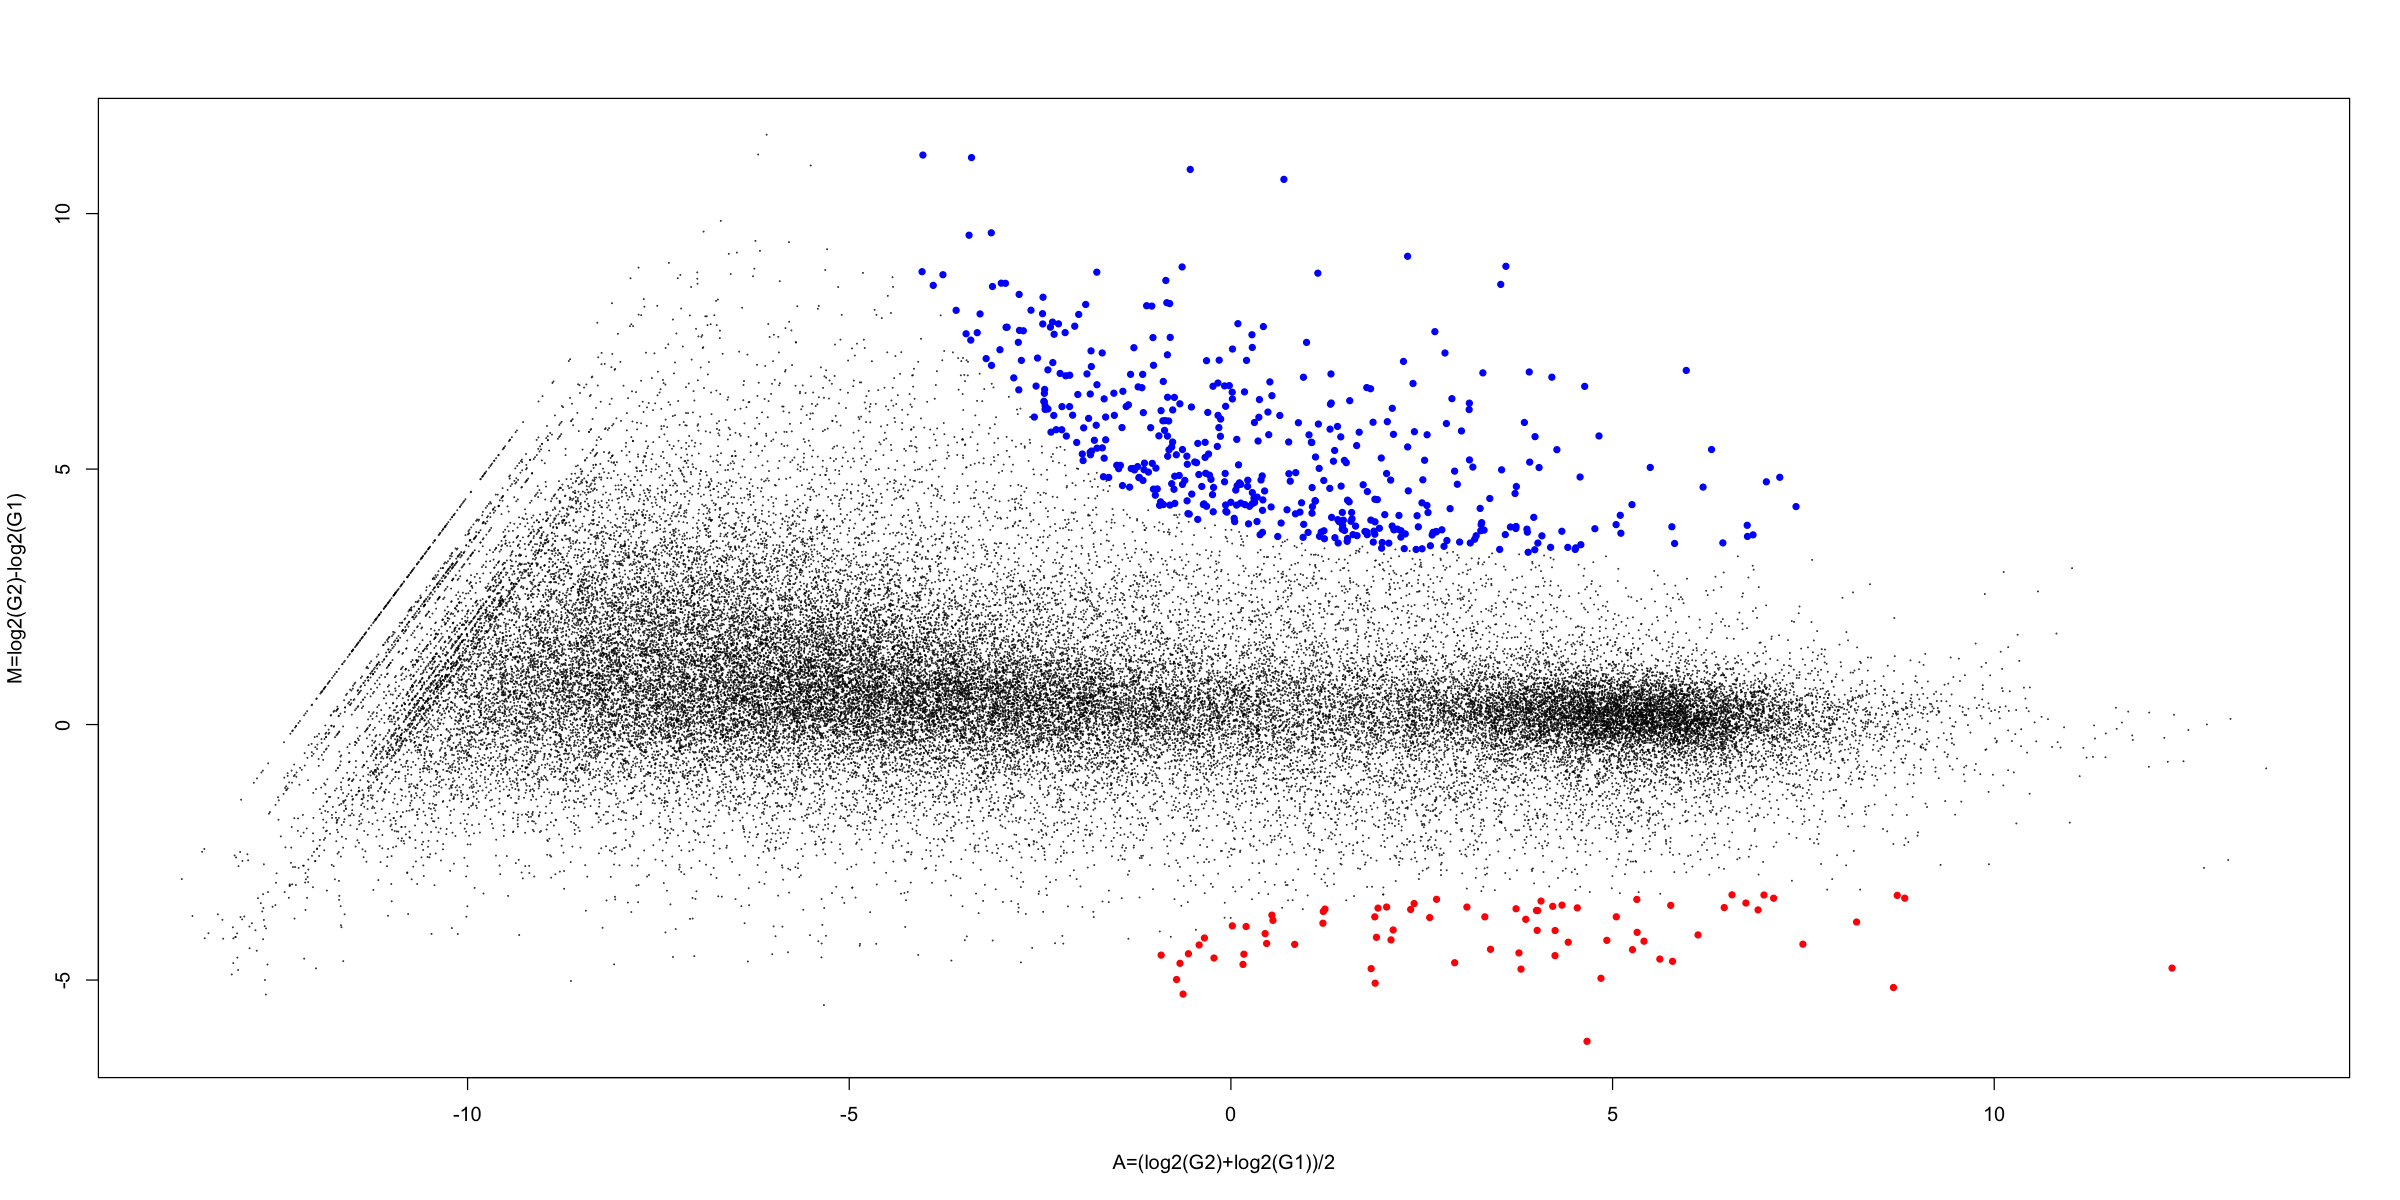

In [47]:
#RPM正規化後のデータでM-A plotを描画（するための基礎情報取得）
D <- DGEList(counts = all.data_cpm, group = SampleType)#DGEListオブジェクトを作成してdに格納
D <- calcNormFactors(D)                #TMM正規化係数を計算
norm_f_TMM <- D$samples$norm.factors   #TMM正規化係数の情報を抽出してnorm_f_TMMに格納
names(norm_f_TMM) <- colnames(all.data_cpm)    #norm_f_TMMのnames属性をcolnames(data)で与えている
effective_libsizes <- colSums(all.data_cpm)*norm_f_TMM #effective library sizesというのはlibrary sizesに(TMM)正規化係数を掛けたものなのでそれを計算した結果をeffective_libsizesに格納
RPM_TMM <- sweep(all.data_cpm, 2, 1000000/effective_libsizes, "*") #元のカウントデータをeffective_libsizesで割り（RPMデータと同程度の数値分布にしたいので）1000000を掛けた正規化後のデータをRPM_TMMに格納

DATA <- RPM_TMM                        #RPM_TMMをdataに格納
mean_G1 <- log2(apply(as.matrix(DATA[,SampleType == "Solid Tissue Normal"]), 1, mean))#遺伝子ごとにG1群の平均の対数を計算した結果をmean_G1に格納
mean_G2 <- log2(apply(as.matrix(DATA[,SampleType == "Primary Tumor"]), 1, mean))#遺伝子ごとにG2群の平均の対数を計算した結果をmean_G2に格納
x_axis <- (mean_G1 + mean_G2)/2        #「G1群の平均値」と「G2群の平均値」の平均をとったものがM-A plotのA(x軸の値)に相当するものなのでx_axisに格納)
y_axis <- mean_G2 - mean_G1            #いわゆるlog比(logの世界での引き算)がM-A plotのM(y軸の値)に相当するものなのでy_axisに格納)
DEG_posi_up <- (q.value < param_FDR & FC > 10)    #指定した閾値未満のものの位置情報をDEG_posiに格納
DEG_posi_down <- (q.value < param_FDR & FC < 0.1)

plot(x_axis, y_axis, xlab="A=(log2(G2)+log2(G1))/2", ylab="M=log2(G2)-log2(G1)", pch=20, cex=.1)#MA-plotを描画
points(x_axis[DEG_posi_up], y_axis[DEG_posi_up], col="red", pch=20, cex=1)#DEGを赤色にしている
points(x_axis[DEG_posi_down], y_axis[DEG_posi_down], col="blue", pch=20, cex=1)#DEGを青色にしている

## 10. Modification of geneID

In [48]:
uplist <- strsplit(upDEG,"\\.")
up <- c()
for (i in 1:length(upDEG)){
    up[i] <- uplist[[i]][1]
}

downlist <- strsplit(downDEG,"\\.")
down <- c()
for (i in 1:length(downDEG)){
    down[i] <- downlist[[i]][1]
}

## 11-1. GO (upregulation)

query_size,intersection_size,p_value,term_id,source,term_name,intersection
<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>
38,4,3.185809e-06,REAC:R-HSA-1247673,REAC,Erythrocytes take up oxygen and release carbon dioxide,"ENSG00000167434,ENSG00000188536,ENSG00000206172,ENSG00000244734"
38,4,5.964406e-06,REAC:R-HSA-1480926,REAC,O2/CO2 exchange in erythrocytes,"ENSG00000167434,ENSG00000188536,ENSG00000206172,ENSG00000244734"
38,4,5.964406e-06,REAC:R-HSA-1237044,REAC,Erythrocytes take up carbon dioxide and release oxygen,"ENSG00000167434,ENSG00000188536,ENSG00000206172,ENSG00000244734"
65,3,1.087305e-03,GO:0031838,GO:CC,haptoglobin-hemoglobin complex,"ENSG00000188536,ENSG00000206172,ENSG00000244734"
65,3,1.087305e-03,GO:0005833,GO:CC,hemoglobin complex,"ENSG00000188536,ENSG00000206172,ENSG00000244734"
65,32,1.087305e-03,GO:0005576,GO:CC,extracellular region,"ENSG00000034971,ENSG00000101280,ENSG00000102104,ENSG00000104938,ENSG00000108342,ENSG00000112782,ENSG00000116147,ENSG00000134917,ENSG00000142748,ENSG00000149021,ENSG00000150625,ENSG00000154342,ENSG00000158764,ENSG00000159307,ENSG00000163687,ENSG00000163815,ENSG00000164530,ENSG00000165197,ENSG00000167434,ENSG00000167588,ENSG00000168481,ENSG00000168484,ENSG00000170323,ENSG00000171243,ENSG00000183090,ENSG00000187950,ENSG00000188536,ENSG00000198576,ENSG00000204305,ENSG00000206172,ENSG00000244734,ENSG00000277494"
60,3,1.420453e-03,GO:0031720,GO:MF,haptoglobin binding,"ENSG00000188536,ENSG00000206172,ENSG00000244734"
65,14,2.279745e-03,GO:0098590,GO:CC,plasma membrane region,"ENSG00000105974,ENSG00000108576,ENSG00000112782,ENSG00000134115,ENSG00000150625,ENSG00000155511,ENSG00000161649,ENSG00000167434,ENSG00000168309,ENSG00000168497,ENSG00000168539,ENSG00000198576,ENSG00000204305,ENSG00000277494"
65,3,2.332769e-03,GO:0071682,GO:CC,endocytic vesicle lumen,"ENSG00000188536,ENSG00000206172,ENSG00000244734"


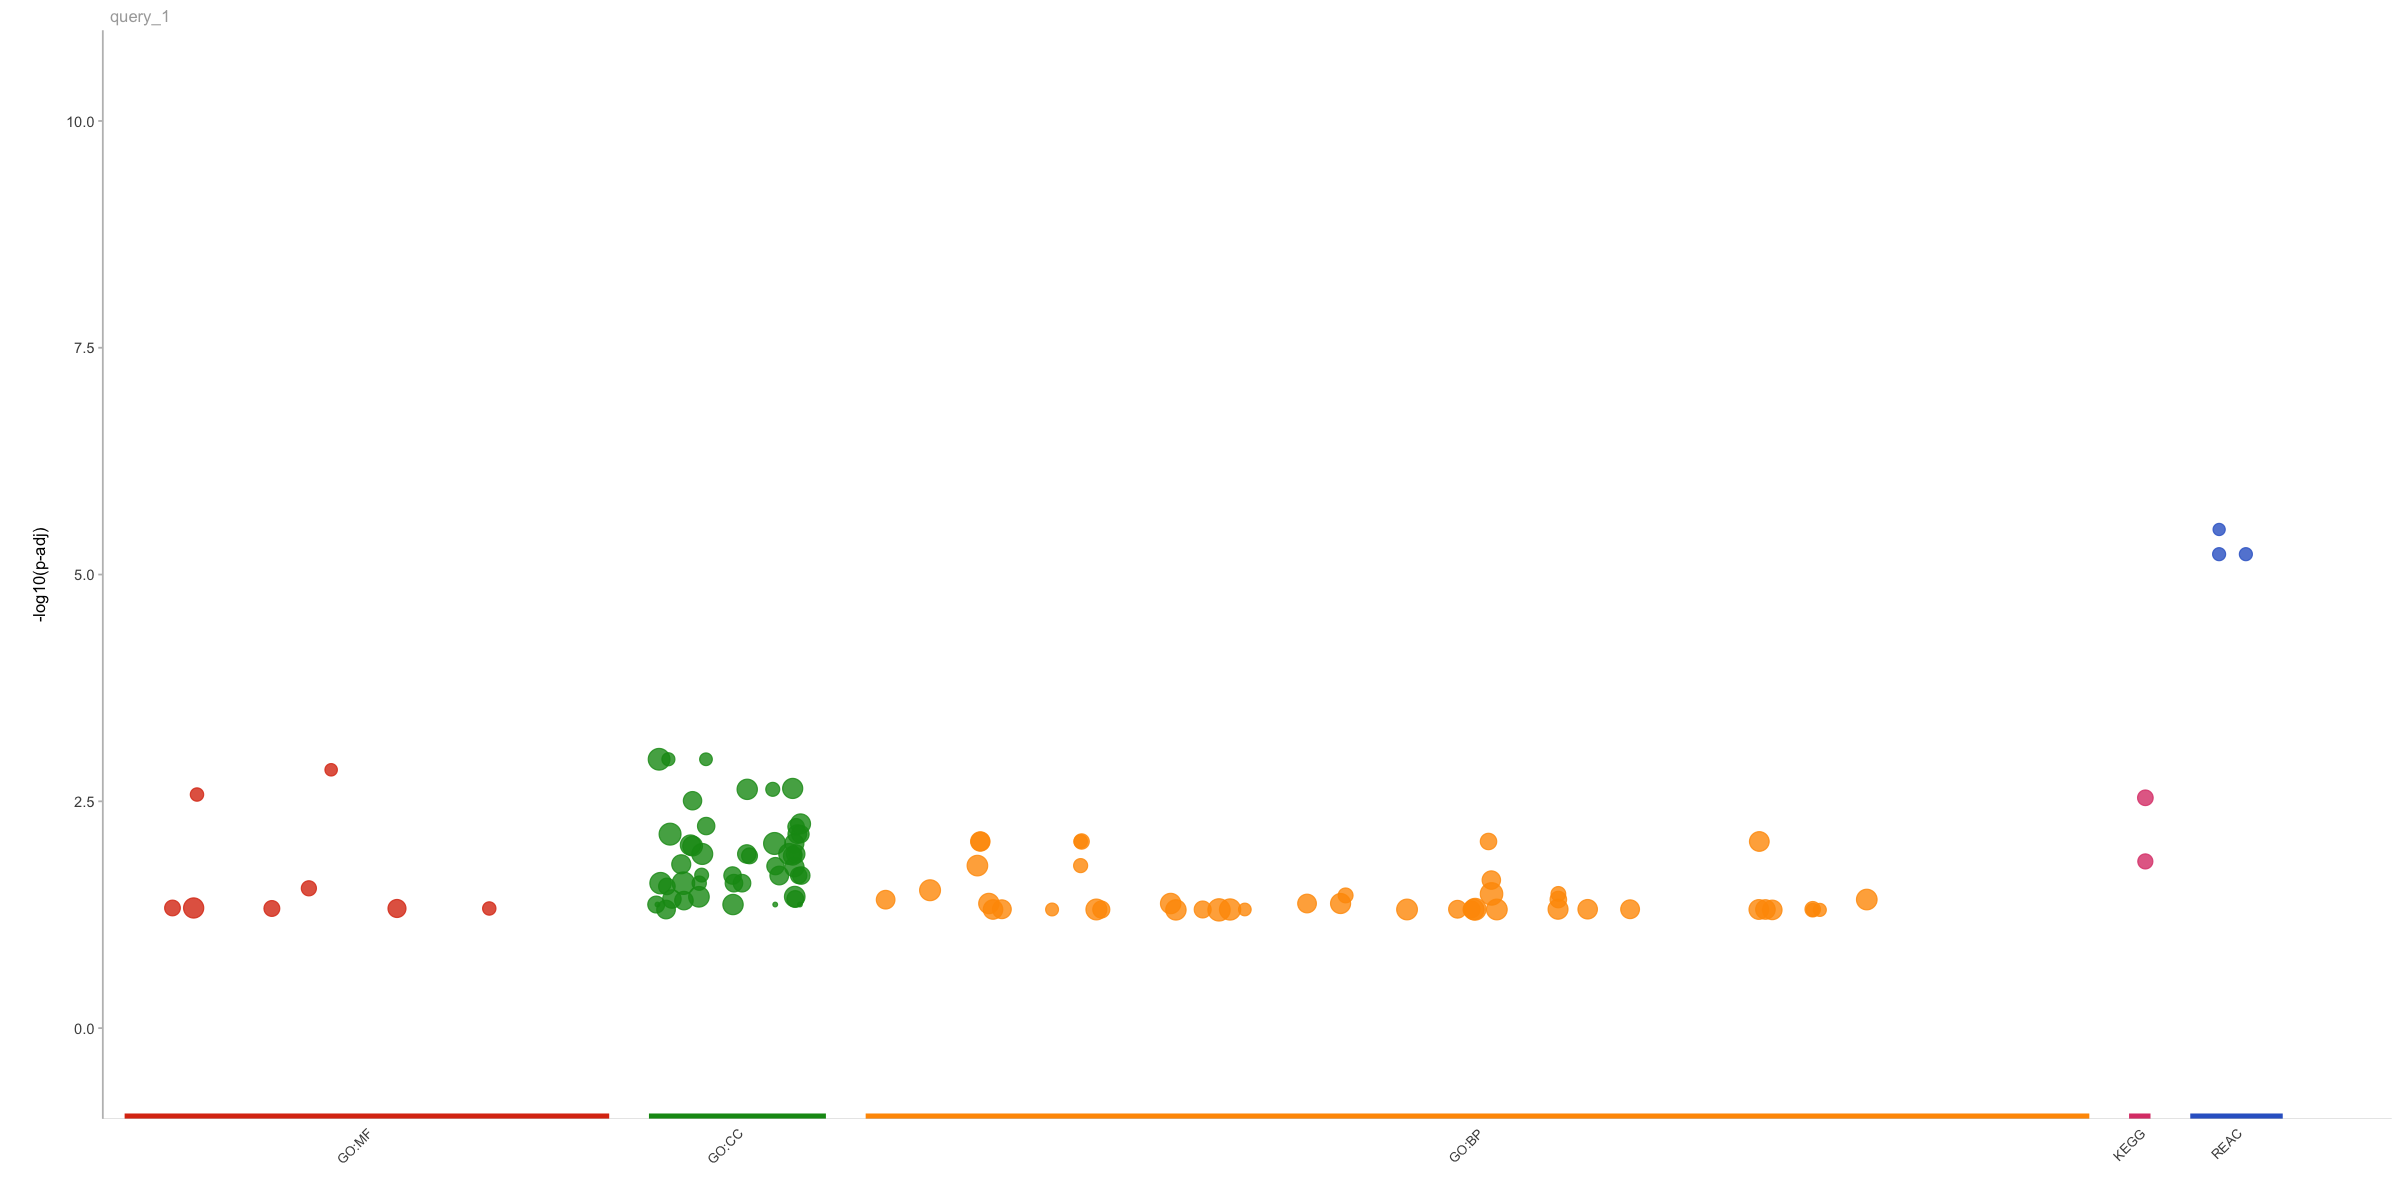

In [49]:
gostres1 <- gost(up, correction_method = "false_discovery_rate",sources = c("GO", "KEGG", "REAC"),evcodes = TRUE,organism = "hsapiens")

if(length(gostres1)>0){

  g1<-data.frame(gostres1$result$query_size,gostres1$result$intersection_size,gostres1$result$p_value,gostres1$result$term_id,gostres1$result$source,gostres1$result$term_name,gostres1$result$intersection)

  colnames(g1)<-sub("gostres1.result.","",colnames(g1))

  g1<-g1[order(g1$p_value),]
  rownames(g1)<-NULL

  p1 <- gostplot(gostres1,interactive=F,capped=F)
}
g1
p1



## 11-2. GO (downregulation)

query_size,intersection_size,p_value,term_id,source,term_name,intersection
<int>,<int>,<dbl>,<fct>,<fct>,<fct>,<fct>
374,151,8.040642e-10,GO:0005576,GO:CC,extracellular region,"ENSG00000002726,ENSG00000006016,ENSG00000006128,ENSG00000007306,ENSG00000010438,ENSG00000011347,ENSG00000029559,ENSG00000047457,ENSG00000060718,ENSG00000065618,ENSG00000069482,ENSG00000072080,ENSG00000074276,ENSG00000078898,ENSG00000081051,ENSG00000087128,ENSG00000088325,ENSG00000089199,ENSG00000091513,ENSG00000099953,ENSG00000100473,ENSG00000100665,ENSG00000102837,ENSG00000104371,ENSG00000104760,ENSG00000105388,ENSG00000105825,ENSG00000106927,ENSG00000109255,ENSG00000110680,ENSG00000113924,ENSG00000115263,ENSG00000115386,ENSG00000115718,ENSG00000117394,ENSG00000117983,ENSG00000118271,ENSG00000118785,ENSG00000120211,ENSG00000122133,ENSG00000122585,ENSG00000122711,ENSG00000123500,ENSG00000123999,ENSG00000124116,ENSG00000124466,ENSG00000125571,ENSG00000127831,ENSG00000128165,ENSG00000128564,ENSG00000129437,ENSG00000129455,ENSG00000129988,ENSG00000131050,ENSG00000133636,ENSG00000134193,ENSG00000134757,ENSG00000134827,ENSG00000135069,ENSG00000135346,ENSG00000136110,ENSG00000136695,ENSG00000137251,ENSG00000137745,ENSG00000138028,ENSG00000139219,ENSG00000140297,ENSG00000143320,ENSG00000143512,ENSG00000143556,ENSG00000144119,ENSG00000145321,ENSG00000145824,ENSG00000146678,ENSG00000148798,ENSG00000150551,ENSG00000154040,ENSG00000156413,ENSG00000157005,ENSG00000158125,ENSG00000160161,ENSG00000160181,ENSG00000160182,ENSG00000160886,ENSG00000162344,ENSG00000162482,ENSG00000163207,ENSG00000163209,ENSG00000163218,ENSG00000163631,ENSG00000163993,ENSG00000164266,ENSG00000164816,ENSG00000164932,ENSG00000165973,ENSG00000166535,ENSG00000166670,ENSG00000166923,ENSG00000167656,ENSG00000167755,ENSG00000168243,ENSG00000169213,ENSG00000169876,ENSG00000169894,ENSG00000170373,ENSG00000170454,ENSG00000171560,ENSG00000171564,ENSG00000171747,ENSG00000173702,ENSG00000175426,ENSG00000177398,ENSG00000178363,ENSG00000178372,ENSG00000180210,ENSG00000182379,ENSG00000183317,ENSG00000183971,ENSG00000184956,ENSG00000185479,ENSG00000185559,ENSG00000186191,ENSG00000186474,ENSG00000186832,ENSG00000186847,ENSG00000188505,ENSG00000188517,ENSG00000189001,ENSG00000189052,ENSG00000196611,ENSG00000197061,ENSG00000198074,ENSG00000198183,ENSG00000198610,ENSG00000198732,ENSG00000198788,ENSG00000204866,ENSG00000204941,ENSG00000204983,ENSG00000205420,ENSG00000205426,ENSG00000206073,ENSG00000206075,ENSG00000211892,ENSG00000211950,ENSG00000243137,ENSG00000258947,ENSG00000262406,ENSG00000273802,ENSG00000275896,ENSG00000276966"
359,84,1.984886e-06,GO:0009888,GO:BP,tissue development,"ENSG00000006016,ENSG00000008300,ENSG00000009709,ENSG00000021826,ENSG00000029559,ENSG00000043039,ENSG00000060718,ENSG00000065618,ENSG00000069011,ENSG00000069482,ENSG00000074276,ENSG00000090932,ENSG00000100473,ENSG00000101842,ENSG00000103449,ENSG00000104371,ENSG00000107159,ENSG00000115718,ENSG00000117148,ENSG00000117724,ENSG00000118785,ENSG00000119547,ENSG00000122585,ENSG00000123364,ENSG00000123388,ENSG00000123572,ENSG00000127831,ENSG00000129437,ENSG00000131668,ENSG00000134757,ENSG00000136099,ENSG00000136110,ENSG00000137203,ENSG00000137745,ENSG00000137868,ENSG00000139219,ENSG00000139352,ENSG00000139515,ENSG00000140297,ENSG00000142700,ENSG00000143320,ENSG00000143556,ENSG00000144452,ENSG00000146678,ENSG00000149948,ENSG00000151632,ENSG00000158125,ENSG00000159184,ENSG00000162992,ENSG00000163207,ENSG00000163209,ENSG00000163216,ENSG00000164093,ENSG00000164509,ENSG00000164932,ENSG00000165474,ENSG00000165973,ENSG00000166923,ENSG00000167755,ENSG00000169297,ENSG00000169469,ENSG00000169903,ENSG00000170162,ENSG00000170454,ENSG00000171431,ENSG00000173404,ENSG00000176887,ENSG00000177398,ENSG00000178372,ENSG00000178919,ENSG00000183856,ENSG00000184486,ENSG00000185479,ENSG00000186193,ENSG00000186474,ENSG00000186832,ENSG00000186847,ENSG00000198443,ENSG00000204610,ENSG00000205420,ENSG00000205426,ENSG00000206075,ENSG00000258947,ENSG00000262406"
374,

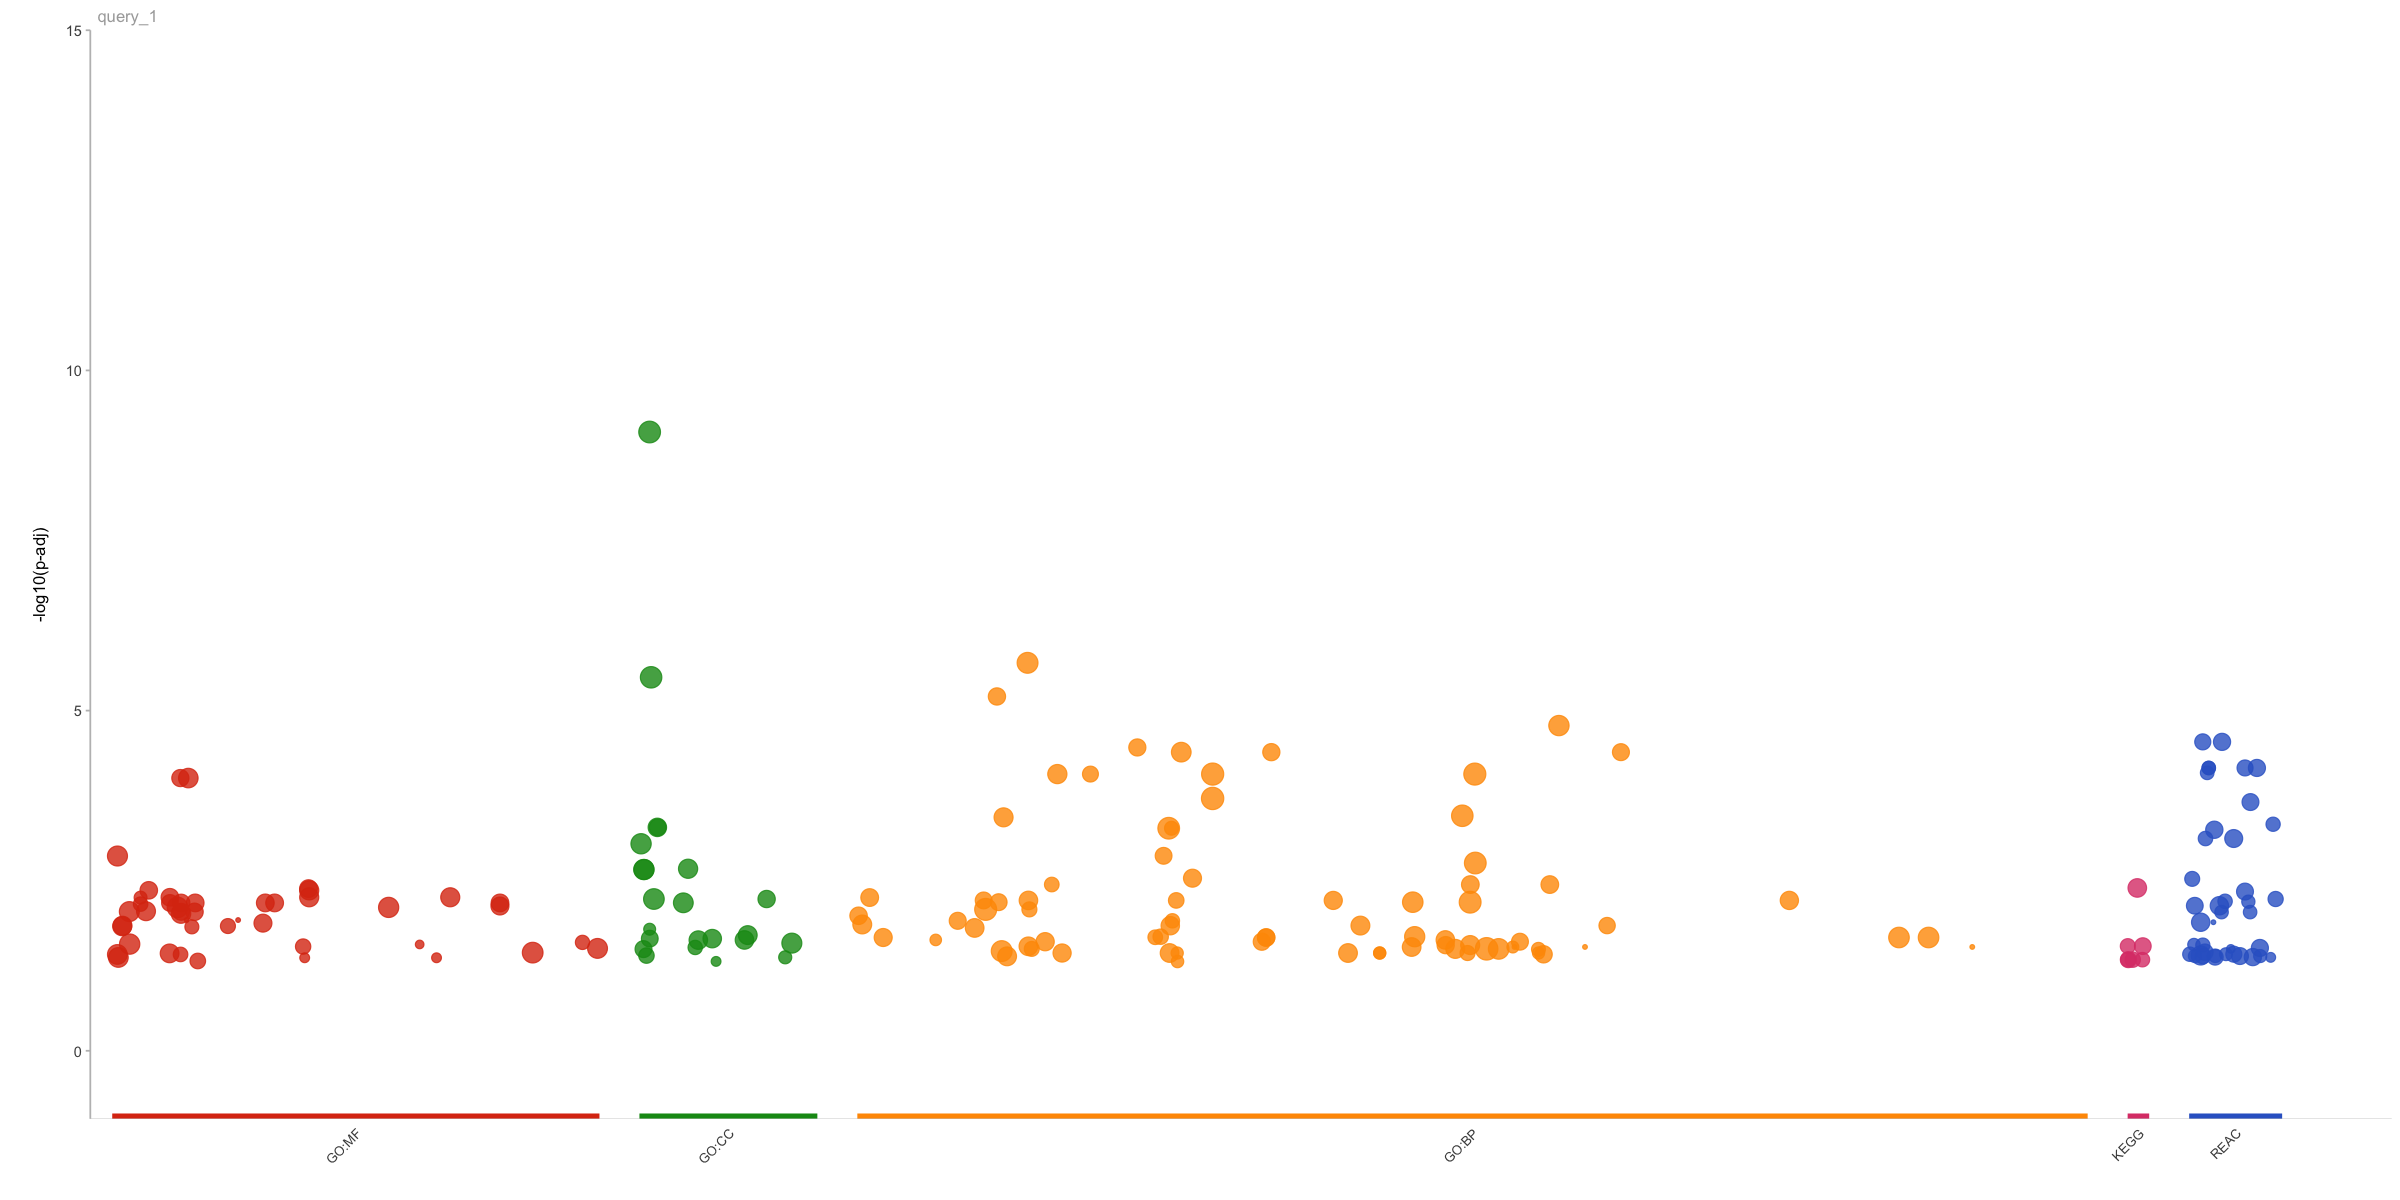

In [50]:
gostres2 <- gost(down, correction_method = "false_discovery_rate",sources = c("GO", "KEGG", "REAC"),evcodes = TRUE,organism = "hsapiens")

if(length(gostres2)>0){

  g2<-data.frame(gostres2$result$query_size,gostres2$result$intersection_size,gostres2$result$p_value,gostres2$result$term_id,gostres2$result$source,gostres2$result$term_name,gostres2$result$intersection)

  colnames(g2)<-sub("gostres2.result.","",colnames(g2))

  g2<-g2[order(g2$p_value),]
  rownames(g2)<-NULL

  p2 <- gostplot(gostres2,interactive=F,capped=F)
}
g2
p2